This notebook preprocesses the dataset and select appropriate animes to save in the final recommendation dataset.

The original UserAnime dataset has around 80M rows, so it is impossible to work it on my machine. One "dirty" workaround I came up with is to only select some animes which has high ranking to be included in the final recommender system.

In [1]:
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Brief analyze of the "anime list"

Just a very simple and dirty process to filter out "valueable" animes to be included in the final database

In [2]:
anime_df = pd.read_csv('anime_cleaned.csv.zip')
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   title_english    3438 non-null   object 
 3   title_japanese   6663 non-null   object 
 4   title_synonyms   4481 non-null   object 
 5   image_url        6666 non-null   object 
 6   type             6668 non-null   object 
 7   source           6668 non-null   object 
 8   episodes         6668 non-null   int64  
 9   status           6668 non-null   object 
 10  airing           6668 non-null   bool   
 11  aired_string     6668 non-null   object 
 12  aired            6668 non-null   object 
 13  duration         6668 non-null   object 
 14  rating           6668 non-null   object 
 15  score            6668 non-null   float64
 16  scored_by        6668 non-null   int64  
 17  rank          

## Analyzing `type`

<AxesSubplot:>

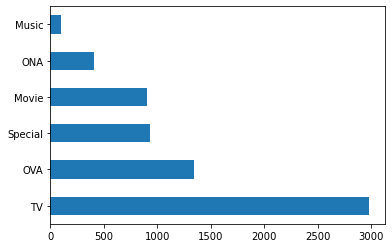

In [3]:
anime_df.type.value_counts().plot(kind='barh')

For the time being, we should only keep "TV" and "Movie" animes.

In [4]:
tvmv_df = anime_df[anime_df.type.isin(['TV', 'Movie'])]
tvmv_df.shape

(3888, 33)

## Analyzing `scored_by`

<AxesSubplot:xlabel='scored_by', ylabel='Density'>

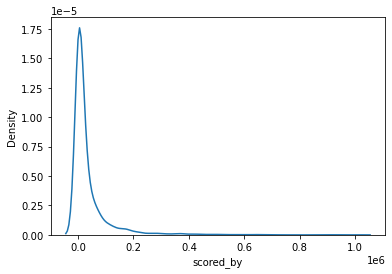

In [5]:
sns.kdeplot(tvmv_df.scored_by)

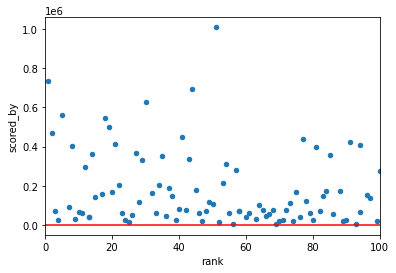

In [6]:
tvmv_df.plot(kind='scatter', x='rank', y='scored_by')
plt.xlim((0, 100))
plt.axhline(y=tvmv_df['rank'].quantile(0.25), color='red')

Cut off animes which are out of top 5000 and have number of people voted for less than the median threshold

In [7]:
tvmv_df = tvmv_df[~((tvmv_df['rank'] > 5000) & (tvmv_df.scored_by < tvmv_df.scored_by.quantile(0.5)))]

In [8]:
tvmv_df.shape

(2961, 33)

# Process our big list: UserAnimeList

**Read necessary columns to memory**

In [9]:
%%time
df = pd.read_csv('UserAnimeList.csv.zip', usecols=['username', 'anime_id', 'my_score'])

CPU times: user 34.5 s, sys: 1.74 s, total: 36.3 s
Wall time: 36.7 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80076112 entries, 0 to 80076111
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   username  object
 1   anime_id  int64 
 2   my_score  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ GB


**Only take animes which are in the given list**

In [11]:
%time df = df[df.anime_id.isin(tvmv_df.anime_id)]

CPU times: user 1.87 s, sys: 1.52 s, total: 3.39 s
Wall time: 3.41 s


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60647322 entries, 0 to 80076111
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   username  object
 1   anime_id  int64 
 2   my_score  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ GB


**Each user may watch an anime multiple times, only keep the one with max score**

In [13]:
%time df = df.groupby(['anime_id', 'username'])['my_score'].max()

CPU times: user 35.6 s, sys: 5.35 s, total: 41 s
Wall time: 41 s


**Pivot the table**

In [14]:
%time df_pivot = df.unstack()

CPU times: user 20.5 s, sys: 11.7 s, total: 32.2 s
Wall time: 32.3 s


In [15]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2961 entries, 1 to 37204
Columns: 281568 entries, ------- to zzzzzzzzzzzzzzz
dtypes: float64(281568)
memory usage: 6.2 GB


In [16]:
del df
gc.collect()

0

In [17]:
%%time
df_pivot.isnull().mean().mean()

CPU times: user 846 ms, sys: 80.6 ms, total: 927 ms
Wall time: 935 ms


0.9272574655410071

92% of the dataframe is null!!

In [18]:
pivot_sparse_df = df_pivot.astype(pd.SparseDtype('int64', np.nan))

In [19]:
del df_pivot
gc.collect()

0

In [20]:
pivot_sparse_df.index.name = None

In [21]:
pivot_sparse_df.head(100)

username,-------,----------,-------------,------o,-----aaa,-----noname-----,----Adrenadroid,----XII----,----phoebelyn,---Kuma---,...,zzzero,zzzett,zzzgaarazzz,zzzsss,zzzu,zzzyeknom0,zzzzz-chan,zzzzzzzBen,zzzzzzzzzzzzzz,zzzzzzzzzzzzzzz
1,8.0,NaN,8.0,9.0,NaN,8.0,NaN,NaN,0.0,NaN,...,8.0,NaN,NaN,NaN,10.0,10.0,NaN,0.0,NaN,NaN
5,8.0,NaN,7.0,NaN,NaN,0.0,NaN,NaN,10.0,NaN,...,8.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,9.0,NaN,NaN,NaN,9.0,0.0,8.0,3.0,NaN,0.0
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,9.0,NaN,NaN,NaN,0.0,NaN,9.0,NaN,NaN,NaN
136,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,...,9.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,10.0,NaN
142,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [25]:
pivot_sparse_df.to_pickle('UserAnimeList_Pivot-3.9.12.pkl')